# Segmentación de fluido patológico en imágenes tomográficas con modelos neuronales


En este Notebook se muestran algunos de los resultados obtenidos con las distintas aproximaciones probadas, y se muestra cómo cargar los modelos y evaluar sobre el conjunto de imágenes.

In [14]:
# importar las librerías
import torch, os
import torch.nn as nn
from models import *
from utils.data import OCTDataset
from torch.utils.data import DataLoader
from trainers import ConvolutionalTrainer
from torch.optim import Adam
from utils.metrics import *
import torchvision.transforms as t
import matplotlib.pyplot as plt 
import numpy as np

# configuración de valores globales
metrics = {'acc': accuracy, 'prec': precision, 'rec': recall, 'fscore': fscore, 'iou': iou}
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
folder = '../OCT-dataset/'
img_files = list(map(lambda x: f'{folder}/images/{x}', os.listdir(f'{folder}/images/')))
mask_files = list(map(lambda x: f'{folder}/masks/{x}', os.listdir(f'{folder}/masks/')))

data = OCTDataset(img_files=img_files, mask_files=mask_files, rsize=DeformUNet.IMAGE_SIZE)
loader = DataLoader(data, batch_size=10, shuffle=False)

Para cargar un modelo específico tenemos que:

1. Construir el modelo con la clase específica implementada en `sseg-oct/models`.
2. Cargar los pesos guardados en un *path* concreto.
3. Cargar el *threshold* obtenido en el entrenamiento.

Por ejemplo, podemos probar a cargar el modelo PSPNet entrenado con *data augmentation*:

In [21]:
# configuramos el path
path = '../results/pspnet-aug/model.pt' 

# creamos el modelo
model = BuilderSMP('pspnet')().to(device)

# creamos el trainer 
optimizer = Adam(model.parameters(), lr=1e-3)
trainer = ConvolutionalTrainer(model, device=device, criterion=nn.BCEWithLogitsLoss(), optimizer=optimizer, metrics=metrics)

# cargamos el modelo
trainer.load_checkpoint(path)

Y podemos validar el rendimiento que tiene sobre todo el conjunto de datos:

In [18]:
trainer.validate(loader)

(0.06286238506436348,
 acc=0.936, prec=0.119, rec=0.501, fscore=0.191, iou=0.106)

Para visualizar los resultados de la red podemos ejecutar estas líneas de código:

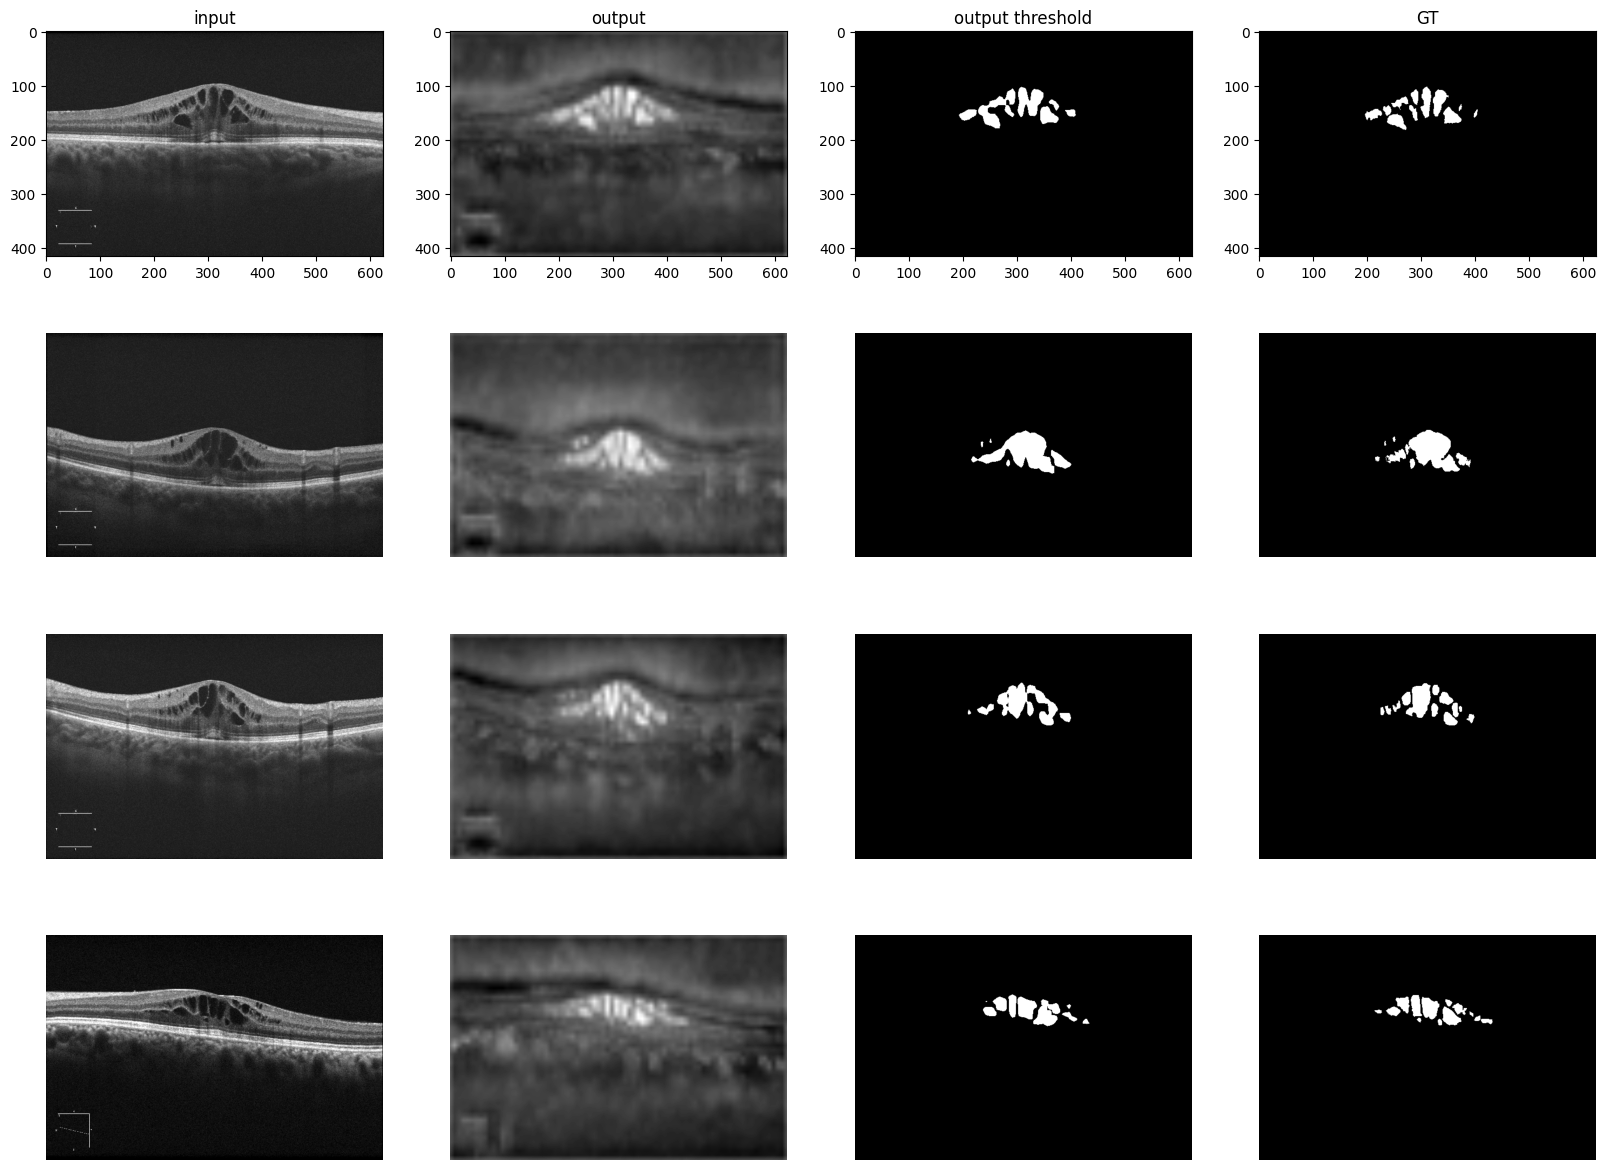

In [6]:

fig, ax = plt.subplots(4, 4, figsize=(20, 15))
indexes = np.random.randint(low=0, high=len(data), size=4)

for i in range(4):
    image, label = data[i]
    output = model(image.reshape(1, *image.shape)).squeeze(0)
    prediction = (output > trainer.threshold)*1.0
    ax[i, 0].imshow(image.squeeze(0), cmap='gray')
    ax[i, 1].imshow(output.detach().squeeze(0), cmap='gray')
    ax[i, 2].imshow(prediction.squeeze(0), cmap='gray')
    ax[i, 3].imshow(label.squeeze(0), cmap='gray')
    if i==0:
        ax[i, 0].set_title('input')
        ax[i, 1].set_title('output')
        ax[i, 2].set_title('output threshold')
        ax[i, 3].set_title('GT')
    else:
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
        ax[i, 3].axis('off')

Además, también podemos observar los errores de la red para diagnostica posibles problemas en el entrenamiento:

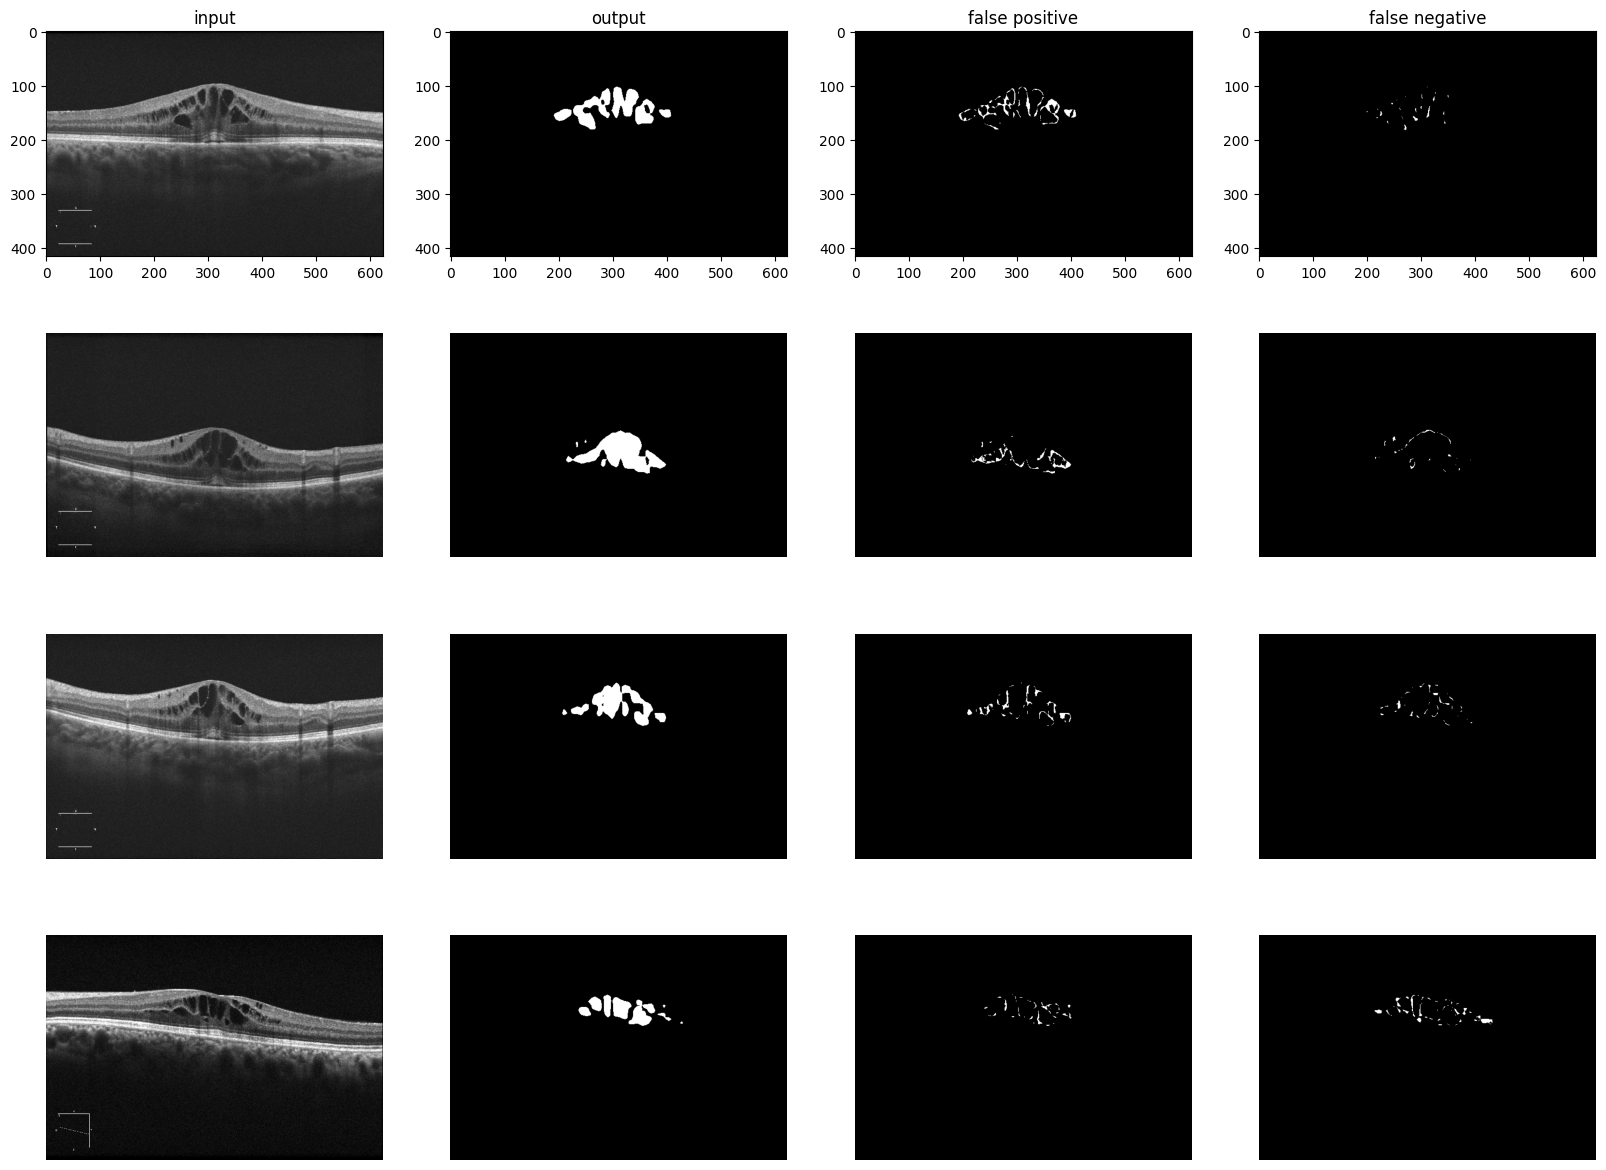

In [13]:
fig, ax = plt.subplots(4, 4, figsize=(20, 15))
indexes = np.random.randint(low=0, high=len(data), size=4)

for i in range(4):
    image, label = data[i]
    output = model(image.reshape(1, *image.shape)).squeeze(0)
    prediction = (output > trainer.threshold)*1.0

    fp = ((label == 0) * (prediction == 1))*1.0
    fn = ((label == 1) * (prediction == 0))*1.0

    ax[i, 0].imshow(image.squeeze(0), cmap='gray')
    ax[i, 1].imshow(prediction.squeeze(0), cmap='gray')
    ax[i, 2].imshow(fp.squeeze(0), cmap='gray')
    ax[i, 3].imshow(fn.squeeze(0), cmap='gray')
    if i==0:
        ax[i, 0].set_title('input')
        ax[i, 1].set_title('output')
        ax[i, 2].set_title('false positive')
        ax[i, 3].set_title('false negative')
    else:
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
        ax[i, 3].axis('off')